In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from utils import import_dataset, get_scores, classes, label2id
import pandas as pd
from numpy import mean, std
from tqdm.notebook import tqdm
import time
from datasets import load_dataset
import pickle
CLASSES = classes

In [2]:
def collect_dataset(seed, 
                    vectorizer=TfidfVectorizer(max_features=5000), 
                    save_vect=False, 
                    history_data='random'):
    
    # returns preprocessed train, test and essays in history test set; trained vectorizer
    
    # main dataset
    dataset = import_dataset(seed, history_data)
    
    y_train = dataset['train']['labels']
    y_test = dataset['test']['labels']
    
    x_train = dataset['train']['text']  
    x_test = dataset['test']['text']
    
    x_train = vectorizer.fit_transform(x_train)
    x_test = vectorizer.transform(x_test)
    
    # essays in history
    eh_dataset = load_dataset('json', data_files='hume_json/essays_in_history.json')
    
    x_eh_test = vectorizer.transform(eh_dataset['train']['text'])
    y_eh_test = eh_dataset['train']['labels']
    
    if save_vect:
        with open('models/tfidf_vectorizer.pkl','wb') as f:
            pickle.dump(vectorizer, f)
    
    return x_train, y_train, x_test, y_test, x_eh_test, y_eh_test, vectorizer

In [3]:
def run_model(model, 
              title, 
              data=(),
              seed=13,
              matrix=True, 
              print_accuracy=True,
              collect_mistakes=False,
              test_eh=True):
    
    if not data:
        data = collect_dataset(seed)
    
    x_train, y_train, x_test, y_test, x_eh_test, y_eh_test, _ = data
    
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    eh_pred = model.predict(x_eh_test)

    if test_eh:
        eh_accuracy, _ = get_scores(eh_pred, y_eh_test, title='essay-history', matrix=True, print_=False)
        print(f'Accuracy on essays in history: {100 - eh_accuracy:.2f}')

    accuracy, f1 = get_scores(pred, y_test, title=title, matrix=matrix, print_=print_accuracy)
                
    out = {'accuracy':accuracy,
           'pred':pred}
                
                
    if collect_mistakes:
        mistakes = []
    
        for i in range(len(y_test)):
            t = y_test[i]
            p = pred[i]

            if t != p:
                mistakes.append((CLASSES[t], CLASSES[p], dataset['test'][i]['title'], dataset['test'][i]['text']))

        df = pd.DataFrame(mistakes, columns=['true', 'predicted', 'title', 'text'])
        out['mistakes'] = df
    
    return out

In [14]:
def run_many(model, iterations=15):
    accuracy_scores = []
    for seed in tqdm([i for i in range(iterations)]):
        acc = run_model(model, '_', seed=seed, matrix=False, print_accuracy=False, test_eh=False)['accuracy']
        accuracy_scores.append(acc)
        
    print('Mean accuracy: ', mean(accuracy_scores))
    print('Standard deviation for accuracy: ', std(accuracy_scores))

## Preparation

In [5]:
CLASSES

['dialogues',
 'dissertation',
 'enquiry',
 'essay',
 'history',
 'political discourses',
 'treatise']

In [8]:
data_random = collect_dataset(13, history_data='random')

# SVM

In [10]:
from sklearn.svm import SVC, LinearSVC

Accuracy on essays in history: 28.36
Accuracy: 77.42
F1: 77.42
Training time: 0.12658953666687012 s


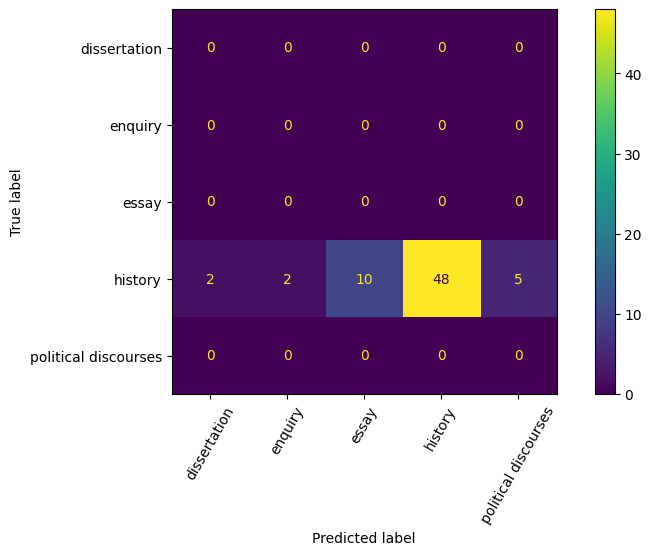

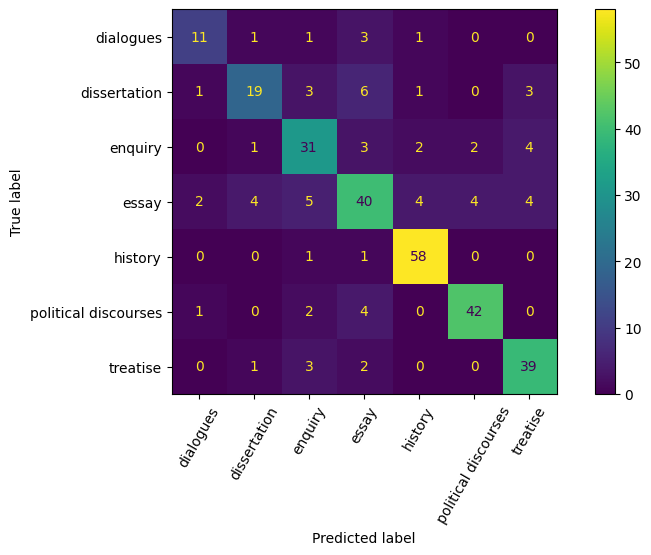

In [11]:
svm_model = LinearSVC()
start = time.time()
d = run_model(svm_model, 'SVM', data=data_random)
print(f'Training time: {time.time()-start} s')

In [15]:
run_many(LinearSVC())

  0%|          | 0/15 [00:00<?, ?it/s]

Mean accuracy:  77.61290322580648
Standard deviation for accuracy:  1.8691129107647964


# Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression

Accuracy on essays in history: 28.36
Accuracy: 75.16
F1: 75.16
Training time: 6.297124862670898 s


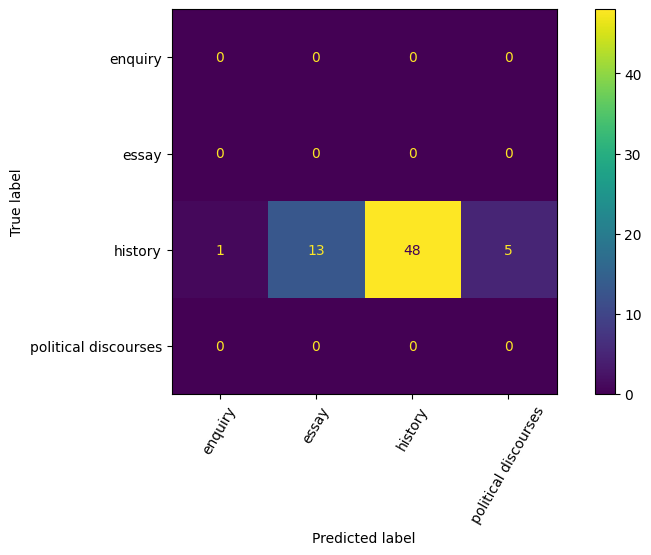

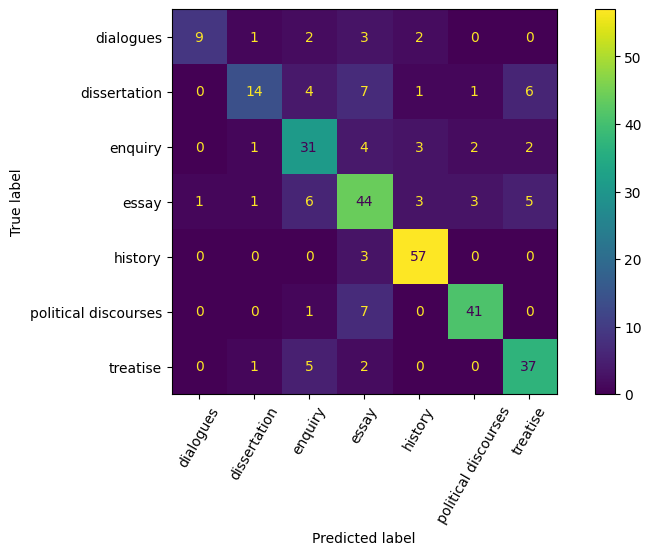

In [18]:
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data_random)
print(f'Training time: {time.time()-start} s')

In [19]:
with open('models/logreg.pkl','wb') as f:
    pickle.dump(logreg_model, f)

In [20]:
# save vectorizer
print(collect_dataset(13, save_vect=True))

(<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 224054 stored elements and shape (2476, 5000)>, [3, 2, 5, 6, 2, 2, 5, 0, 6, 2, 2, 0, 6, 1, 5, 6, 1, 6, 5, 5, 0, 6, 4, 3, 0, 6, 4, 4, 1, 3, 4, 2, 5, 3, 2, 4, 3, 4, 3, 3, 6, 1, 4, 2, 3, 6, 3, 6, 1, 3, 5, 1, 4, 6, 6, 5, 0, 2, 6, 3, 4, 2, 3, 6, 4, 2, 4, 5, 5, 6, 2, 2, 0, 0, 4, 3, 2, 6, 4, 4, 3, 6, 4, 0, 1, 6, 2, 6, 2, 0, 5, 6, 3, 4, 0, 3, 3, 4, 3, 6, 3, 3, 4, 1, 2, 5, 1, 6, 0, 6, 3, 6, 3, 2, 3, 5, 3, 6, 4, 6, 6, 6, 0, 4, 2, 0, 6, 6, 6, 5, 5, 5, 2, 3, 4, 4, 2, 4, 2, 2, 3, 0, 0, 3, 6, 1, 0, 4, 2, 0, 2, 2, 5, 4, 5, 2, 0, 2, 2, 5, 0, 3, 2, 0, 6, 4, 3, 1, 2, 6, 1, 5, 6, 4, 5, 5, 0, 5, 4, 2, 0, 5, 2, 4, 4, 6, 5, 5, 5, 1, 3, 3, 2, 2, 4, 6, 5, 4, 4, 2, 3, 3, 0, 2, 6, 2, 4, 3, 0, 4, 2, 6, 6, 3, 6, 4, 1, 1, 2, 0, 2, 4, 3, 2, 2, 5, 2, 1, 2, 5, 5, 4, 3, 1, 3, 1, 6, 6, 1, 3, 4, 6, 4, 3, 3, 2, 2, 6, 3, 6, 4, 1, 4, 3, 5, 3, 5, 0, 2, 1, 4, 0, 6, 2, 6, 2, 2, 5, 3, 5, 6, 4, 0, 2, 3, 5, 6, 6, 6, 2, 2, 3, 4, 1, 2, 5, 4, 6, 2, 3, 3, 4, 3, 4, 4, 6, 

In [21]:
run_many(LogisticRegression(), 15)

  0%|          | 0/15 [00:00<?, ?it/s]

Mean accuracy:  74.53763440860214
Standard deviation for accuracy:  1.8678753333856735


# New data

In [29]:
data_automatic = collect_dataset(13, history_data='automatic')

Accuracy on essays in history: 71.64
Accuracy: 81.79
F1: 81.79
Training time: 0.0863499641418457 s


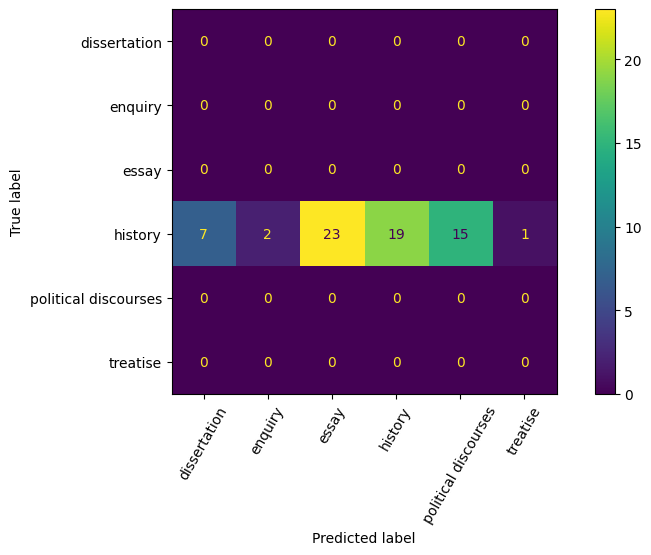

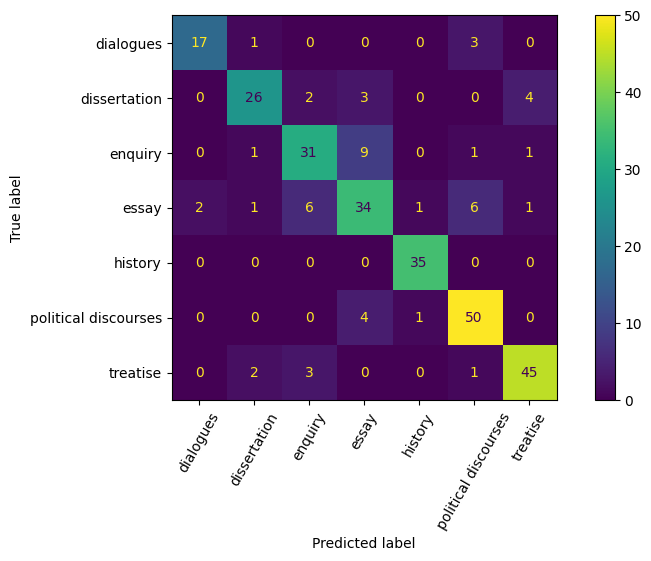

In [30]:
svm_model = LinearSVC()
start = time.time()
d = run_model(svm_model, 'SVM', data=data_automatic)
print(f'Training time: {time.time()-start} s')

Accuracy on essays in history: 74.63
Accuracy: 76.29
F1: 76.29
Training time: 4.3566999435424805 s


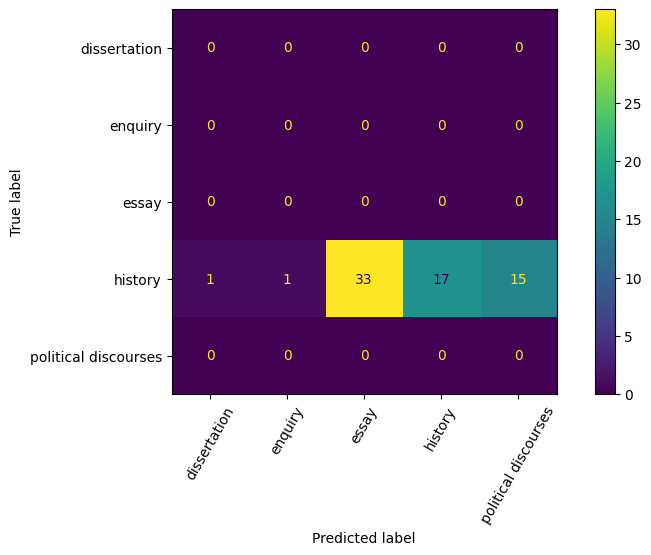

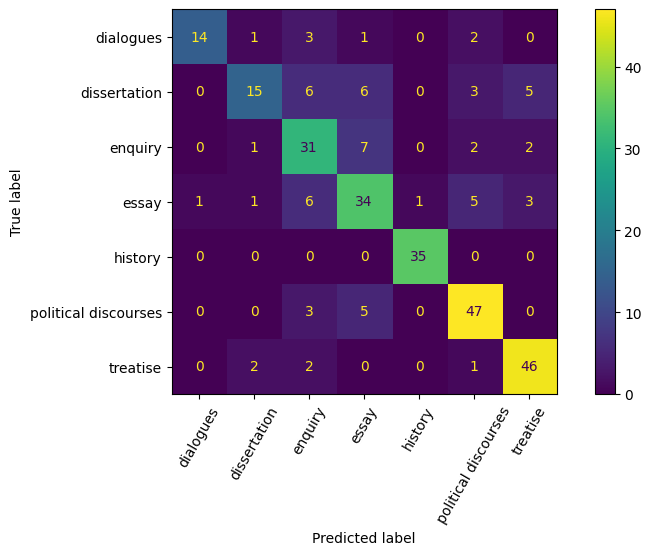

In [31]:
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data_automatic)
print(f'Training time: {time.time()-start} s')

# Additional experiments

## Collecting mistakes

In [ ]:
svm_mistakes = run_model(svm_model, 
                         'SVM', 
                         matrix=False, 
                         collect_mistakes=True, 
                         print_accuracy=False)['mistakes']

In [ ]:
logreg_mistakes = run_model(logreg_model, 
                            'Logreg', 
                            matrix=False, 
                            collect_mistakes=True, 
                            print_accuracy=False)['mistakes']

In [ ]:
mistakes_merged = logreg_mistakes.merge(svm_mistakes, how='outer')

In [ ]:
mistakes_merged.to_csv('mistakes.csv', index=False)

## Extracting logits / probabilities

In [28]:
# LinearSVC does not have probablities 
# SVC does, but it does not allow to look into features

pred1 = svm_model.predict(x_eh_test)
# pred2 = svm_model.predict_log_proba(x_eh_test)
# pred3 = svm_model.predict_proba(x_eh_test)

In [13]:
logreg_proba = logreg_model.predict_proba(x_eh_test) # 67 x 7

In [14]:
sure = 0
unsure = 0

for line in logreg_proba:
    
    line = list(line)
    m = max(line) # first max
    ind = line.index(m)
    line.pop(ind)
    
    m2 = max(line) # second max
    ind2 = line.index(m2)
#     print(m, ind, m2, ind2)
    
    if m2 > 0.15: # if second max is more than treshold, the model is not super sure, and it is curious
        unsure += 1
    else:
        sure += 1

        
print(f'Sure: {sure}, unsure: {unsure}')

Sure: 16, unsure: 51


# Other models

## Gradient boosting

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

Accuracy on essays in history: 40.30
Accuracy: 68.71
F1: 68.71
Training time: 27.90567660331726 s


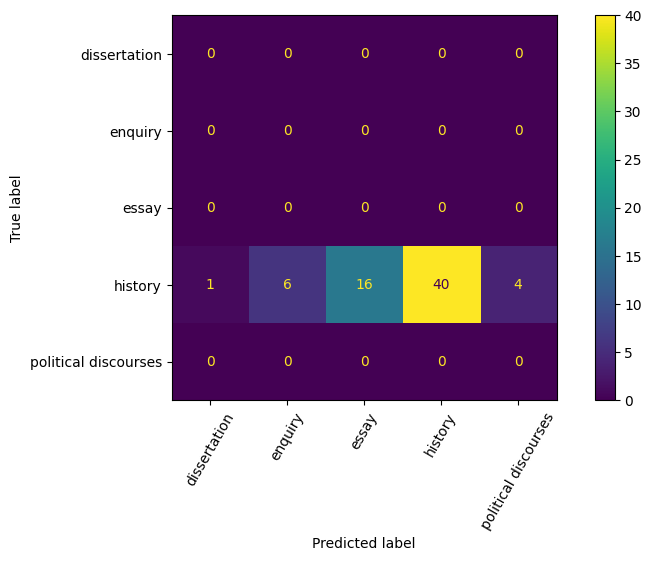

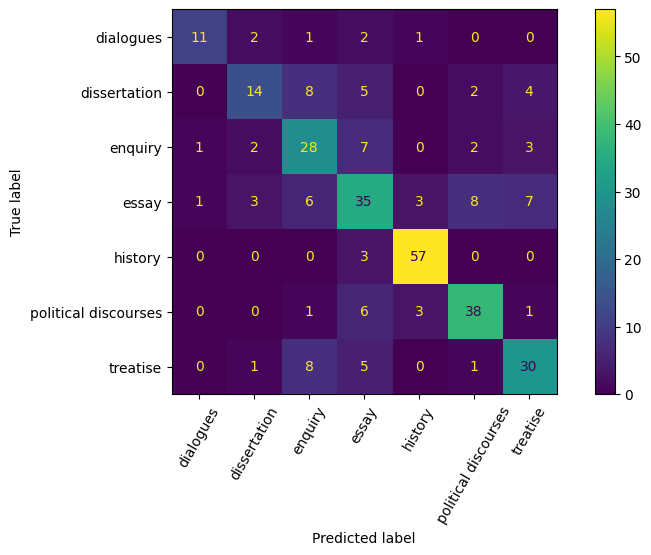

In [23]:
gb_model = GradientBoostingClassifier()
start = time.time()
run_model(gb_model, 'Gradient Boost', data=data_random)
print(f'Training time: {time.time()-start} s')

## Decision tree

In [24]:
from sklearn.tree import DecisionTreeClassifier

Accuracy on essays in history: 50.75
Accuracy: 44.84
F1: 44.84
Training time: 0.4762437343597412 s


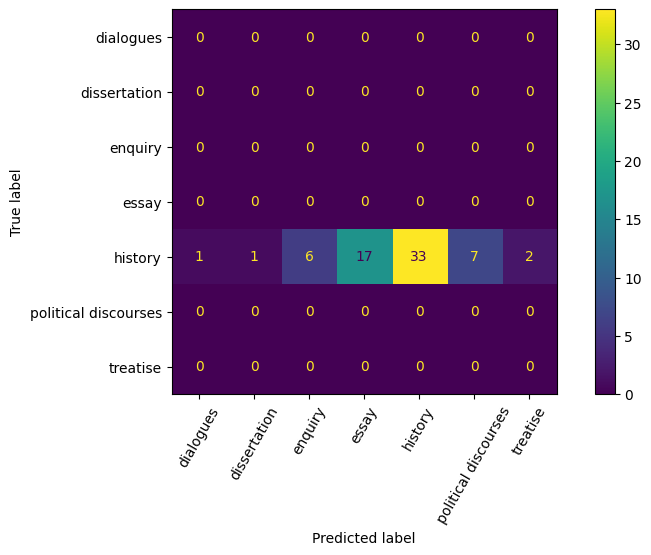

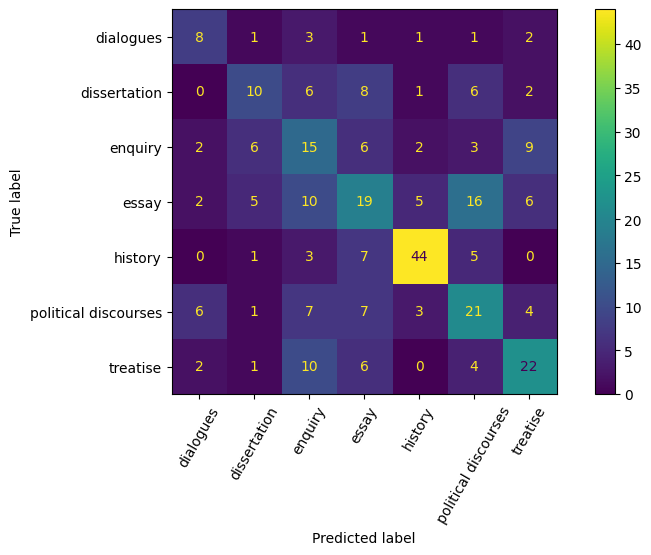

In [25]:
dt_model = DecisionTreeClassifier()
start = time.time()
run_model(dt_model, 'Decision Tree', data=data_random)
print(f'Training time: {time.time()-start} s')

## Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

Accuracy on essays in history: 34.33
Accuracy: 53.87
F1: 53.87
Training time: 0.1802961826324463 s


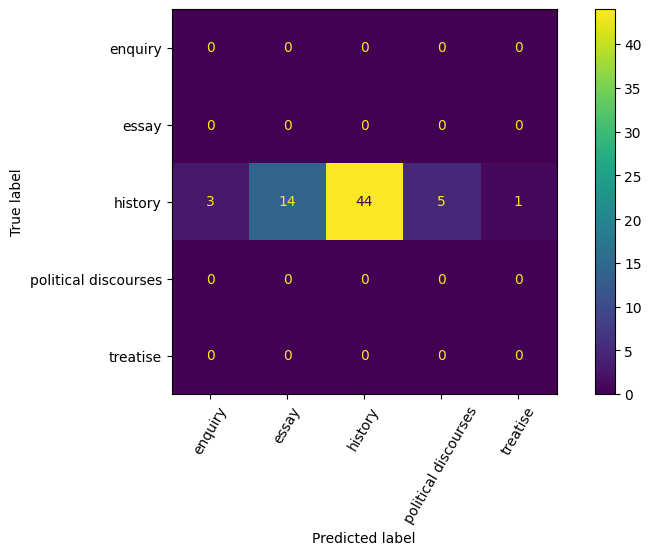

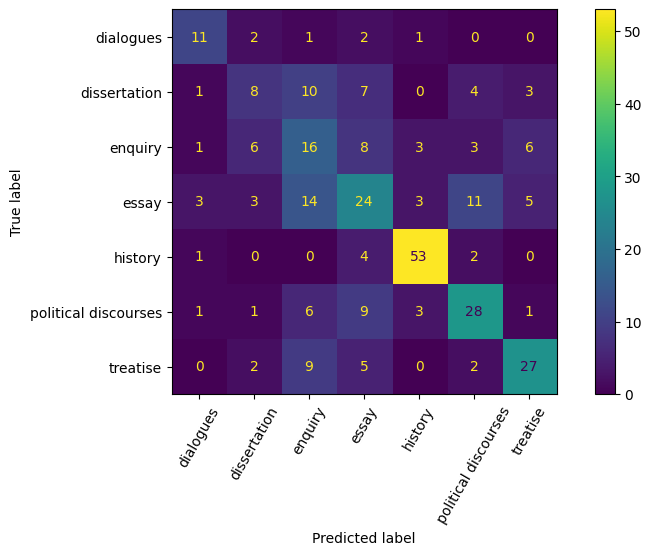

In [27]:
forest_model = RandomForestClassifier(n_estimators=10)
start = time.time()
run_model(forest_model, 'Random Forest', data=data_random)
print(f'Training time: {time.time()-start} s')